In [1]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
train_data = pd.read_csv("used_car_train_20200313.csv", sep=' ')
test = pd.read_csv("used_car_testB_20200421.csv", sep=' ')

## 输出数据的大小信息
print('Train data shape:',train_data.shape)
print('TestA data shape:',test.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [3]:
## 通过.head() 简要浏览读取数据的形式
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [4]:
## 通过 .info() 简要可以看到对应一些数据列名，以及NAN缺失信息
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [5]:
## 通过 .columns 查看列名
train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SaleID             50000 non-null  int64  
 1   name               50000 non-null  int64  
 2   regDate            50000 non-null  int64  
 3   model              50000 non-null  float64
 4   brand              50000 non-null  int64  
 5   bodyType           48496 non-null  float64
 6   fuelType           47076 non-null  float64
 7   gearbox            48032 non-null  float64
 8   power              50000 non-null  int64  
 9   kilometer          50000 non-null  float64
 10  notRepairedDamage  50000 non-null  object 
 11  regionCode         50000 non-null  int64  
 12  seller             50000 non-null  int64  
 13  offerType          50000 non-null  int64  
 14  creatDate          50000 non-null  int64  
 15  v_0                50000 non-null  float64
 16  v_1                500

In [7]:
## 通过 .describe() 可以查看数值特征列的一些统计信息
train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [8]:
test.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,48496.000000,47076.000000,48032.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,224999.500000,68505.606100,2.003401e+07,47.64948,8.087140,1.793736,0.376498,0.226953,119.766960,12.598260,...,0.248147,0.044624,0.124693,0.058198,0.062113,0.019633,0.002759,0.004342,0.004570,-0.007209
std,14433.901067,61032.124271,5.351615e+04,49.90741,7.899648,1.764970,0.549281,0.418866,206.313348,3.912519,...,0.045836,0.051664,0.201440,0.029171,0.035723,3.764095,3.289523,2.515912,1.287194,1.044718
min,200000.000000,1.000000,1.991000e+07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.119719,-5.662163,-8.291868,-4.157649,-6.098192
25%,212499.750000,11315.000000,1.999100e+07,11.00000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243436,0.000035,0.062519,0.035413,0.033880,-3.675196,-1.963928,-1.865406,-1.048722,-0.440706
50%,224999.500000,52215.000000,2.003091e+07,30.00000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257818,0.000801,0.095880,0.056804,0.058749,1.632134,-0.375537,-0.138943,-0.036352,0.136849
75%,237499.250000,118710.750000,2.007110e+07,66.00000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265263,0.101654,0.125470,0.079387,0.087624,2.846205,1.263451,1.775632,0.945239,0.685555
max,249999.000000,196808.000000,2.015121e+07,246.00000,39.000000,7.000000,6.000000,1.000000,19211.000000,15.000000,...,0.291176,0.153403,1.411559,0.157458,0.211304,12.177864,18.789496,13.384828,5.635374,2.649768


# 数据清洗

## 异常值处理

In [9]:
train_data['notRepairedDamage'].value_counts()
#train_data['notRepairedDamage'].describe()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

In [10]:
train_data['notRepairedDamage'].replace('-', '0.0', inplace=True)
test['notRepairedDamage'].replace('-', '0.0', inplace=True)

In [11]:
train_data['power'].describe()

train_data['power'][train_data['power']>600] = 600  # 不要忘记最后['power']
test['power'][test['power']>600] = 600

In [12]:
train_data['power'].describe()

count    150000.000000
mean        116.860973
std          70.075256
min           0.000000
25%          75.000000
50%         110.000000
75%         150.000000
max         600.000000
Name: power, dtype: float64

In [13]:
test['power'].describe()

count    50000.00000
mean       116.51788
std         70.48107
min          0.00000
25%         75.00000
50%        110.00000
75%        150.00000
max        600.00000
Name: power, dtype: float64

## 缺失值补全

In [14]:
print(train_data.isnull().sum())
print(test.isnull().sum())

SaleID                  0
name                    0
regDate                 0
model                   1
brand                   0
bodyType             4506
fuelType             8680
gearbox              5981
power                   0
kilometer               0
notRepairedDamage       0
regionCode              0
seller                  0
offerType               0
creatDate               0
price                   0
v_0                     0
v_1                     0
v_2                     0
v_3                     0
v_4                     0
v_5                     0
v_6                     0
v_7                     0
v_8                     0
v_9                     0
v_10                    0
v_11                    0
v_12                    0
v_13                    0
v_14                    0
dtype: int64
SaleID                  0
name                    0
regDate                 0
model                   0
brand                   0
bodyType             1504
fuelType             2924

In [15]:
train_data['model'].fillna(train_data['model'].mode()[0],inplace = True)
# print(train_data.isnull().sum())
test['model'].fillna(test['model'].mode()[0],inplace = True)
# print(test['model'].isnull().sum())

train_data['bodyType'].value_counts()
train_data['bodyType'].fillna(train_data['bodyType'].mode()[0],inplace = True)
# print(train_data.isnull().sum())
test['bodyType'].fillna(test['bodyType'].mode()[0],inplace = True)

train_data['fuelType'].value_counts()
train_data['fuelType'].fillna(train_data['fuelType'].mode()[0],inplace = True)
# print(train_data.isnull().sum())
test['fuelType'].fillna(test['fuelType'].mode()[0],inplace = True)

train_data['gearbox'].value_counts()
train_data['gearbox'].fillna(train_data['gearbox'].mode()[0],inplace = True)
# print(train_data.isnull().sum())
test['gearbox'].fillna(test['gearbox'].mode()[0],inplace = True)

In [16]:
# 特征选择
# drop_cols = ['SaleID', 'regDate', 'creatDate', 'offerType', 'price']
drop_cols = ['SaleID', 'name', 'offerType', 'price']
feature_cols = [col for col in train_data.columns if col not in drop_cols]
print(feature_cols)

['regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']


In [17]:
# 查看数值类型
#train_data.info()
numerical_cols = train_data[feature_cols].select_dtypes(exclude='object').columns.to_list()
numerical_cols.remove('regDate') # 剔除日期单独处理
numerical_cols.remove('creatDate')
print('numerical_cols :' + str(len(numerical_cols)))
print(numerical_cols)
print('************************************************************')
# 查看分类类型
categorical_cols = train_data[feature_cols].select_dtypes(include='object').columns.to_list()
print('categorical_cols :'+ str(len(categorical_cols)))
print(categorical_cols)
print('************************************************************')
# 查看日期类型
date_cols = ['regDate','creatDate']
print('date_cols :'+ str(len(date_cols)))
print(date_cols)

numerical_cols :24
['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']
************************************************************
categorical_cols :1
['notRepairedDamage']
************************************************************
date_cols :2
['regDate', 'creatDate']


In [ ]:
# 数值型字段可视化
def plot_continuous(train,feature,target):
    sns.set( palette="muted", color_codes=True)
#     sns.set_style(style = "darkgrid")   #sns.set_style("darkgrid", {"axes.facecolor": "pink"})
#     plt.figure(figsize = (10,8))  # 画布放在这里，就无法绘制多个子图

    # plt.subplot(1, 1, 1)
    g = sns.distplot(train[feature].dropna(), bins=20,color = "b")  # 频数
    g = sns.kdeplot(train[feature].notnull(), ax = g, color = "Blue", shade= False)
    g.set_xlabel(feature) #,fontsize = 15
    g.set_ylabel("Proportion")
    
    # plt.xlim(0,80)
    # plt.ylim(0,0.04)
    plt.grid(True)
    

plt.figure(figsize=(20, 16))
index = 1
for num in numerical_cols:
    plt.subplot(6,4,index)
    plot_continuous(train_data,num,'price')
    index +=1
plt.tight_layout()
plt.show()
# learning ：
# 离散型数值字段：['bodyType','fuelType','gearbox','kilometer'] => 实际上是类别型
# 连续型数值字段：剩下的

In [19]:
# numerical 剔除 ['model','brand',bodyType','fuelType','gearbox','kilometer']
numerical_cols= [ i for i in numerical_cols if (i not in ['model','brand','bodyType','fuelType','gearbox','kilometer']) ] 
numerical_cols

['power',
 'regionCode',
 'seller',
 'v_0',
 'v_1',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14']

In [20]:
# categorical 增加 ['bodyType','fuelType','gearbox','kilometer']
categorical_cols.extend(['model','brand','bodyType','fuelType','gearbox','kilometer'])
categorical_cols

['notRepairedDamage',
 'model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'kilometer']

In [21]:
import warnings
warnings.filterwarnings('ignore')
#X_data.info()
train_data['notRepairedDamage'] = train_data['notRepairedDamage'].astype('float64')
test['notRepairedDamage'] = test['notRepairedDamage'].astype('float64')

In [ ]:
def plot_discrete(train,feature,target):

    sns.set( palette="muted", color_codes=True)

#     plt.figure(figsize = (20,5)) # 画布放在这里，就无法在for in 内部绘制多个子图

    # plot count for feature
    plt.subplot(7,2,2*index-1)
    w = train[feature].value_counts()
    b = sns.barplot(x=w.index, y=w.values)
    b.set_xlabel(feature,fontsize = 10)
    b.set_ylabel("Count",fontsize = 10)
    b.legend(fontsize = 14,loc = 'upper right')
    del w

    #plot target mean of feature
    plt.subplot(7,2,2*index)
    v = train.groupby(feature,as_index=False)[target].agg({feature + '_'+target+'_mean':'mean'}).reset_index()
    g = sns.barplot(x = feature, y = feature + '_'+target+'_mean',data = v)
    g = g.set_ylabel("Mean")
    del v


plt.figure(figsize=(18, 18))
index = 1
for cat in categorical_cols:
    plot_discrete(train_data,cat,'price')
    index +=1
plt.tight_layout()
plt.show()

* body Type :车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7
* kilometer 和price 高度负相关 ; notrepairedDamage,gearbox,fuelType 和 price 也有一定关联
* fuelType :燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6
* model ,brand 不好说

In [ ]:
# 连续型数值字段和目标字段price的相关关系
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = numerical_cols.copy() # 需要copy(),否则numerical_cols会被改掉
num_cols.append('price')
#匿名特征v_0,v_3,v_8,v_12与'price'相关性很高
corr_num = abs(train_data[train_data['price'].notnull()][num_cols].corr())
plt.figure(figsize=(20, 16))
sns.heatmap(corr_num, annot=True)

In [24]:
# corr_num = abs(train_data[train_data['price'].notnull()][num_cols].corr())
print('Featured hights correlation with Target_column')
print('Feature\t Correlation')
Target_Corr = corr_num["price"] # update target column
# Target_Corr = Target_Corr[np.argsort(abs(Target_Corr), axis = 0)[::-1]][1:] #sort in descending order
Target_Corr = Target_Corr[np.argsort(Target_Corr, axis = 0)[::-1]][1:] #sort in descending order
print(Target_Corr)

Featured hights correlation with Target_column
Feature	 Correlation
v_3           0.730946
v_12          0.692823
v_8           0.685798
v_0           0.628397
power         0.556400
v_11          0.275320
v_10          0.246175
v_9           0.206205
v_5           0.164317
v_4           0.147085
v_2           0.085322
v_6           0.068970
v_1           0.060914
v_7           0.053024
v_14          0.035911
regionCode    0.014036
v_13          0.013993
seller        0.002004
Name: price, dtype: float64


## 对日期格式进行处理

In [25]:
"""
feature_cols.append('regDate_year')
feature_cols.append('creatDate_year')
print(feature_cols)

"""
train_data['regDate_year'] = train_data['regDate'].apply(lambda x : int(str(x)[0:4]))
test['regDate_year'] = test['regDate'].apply(lambda x : int(str(x)[0:4]))

train_data['creatDate_year'] = train_data['creatDate'].apply(lambda x : int(str(x)[0:4]))
test['creatDate_year'] = test['creatDate'].apply(lambda x : int(str(x)[0:4]))

# train_data['regDate_year'].value_counts()

In [26]:
# num_cols.append('car_year')
num_cols.append('regDate_year')
num_cols.append('creatDate_year')
corr_num = abs(train_data[train_data['price'].notnull()][num_cols].corr())
print('Featured hights correlation with Target_column')
print('Feature\t Correlation')
Target_Corr = corr_num["price"] # update target column
Target_Corr = Target_Corr[np.argsort(abs(Target_Corr), axis = 0)[::-1]][1:] #sort in descending order
# Target_Corr = Target_Corr[np.argsort(Target_Corr, axis = 0)[::-1]] #sort in descending order
print(Target_Corr)

Featured hights correlation with Target_column
Feature	 Correlation
v_3               0.730946
v_12              0.692823
v_8               0.685798
v_0               0.628397
regDate_year      0.611814
power             0.556400
v_11              0.275320
v_10              0.246175
v_9               0.206205
v_5               0.164317
v_4               0.147085
v_2               0.085322
v_6               0.068970
v_1               0.060914
v_7               0.053024
v_14              0.035911
regionCode        0.014036
v_13              0.013993
seller            0.002004
creatDate_year    0.001702
Name: price, dtype: float64


## 交叉统计特征

### categorical_cols-price

In [27]:
categorical_cols.remove('notRepairedDamage')
categorical_cols.remove('kilometer')
categorical_cols

['model', 'brand', 'bodyType', 'fuelType', 'gearbox']

In [28]:
#类别特征对价格的统计最大，最小，平均值等等
# selected_categorical_cols = categorical_cols.copy()
selected_categorical_cols = ['brand']
for col in selected_categorical_cols:
    t = train_data.groupby(col,as_index=False)['price'].agg(
        {col+'_count':'count',col+'_price_max':'max',col+'_price_median':'median',
         col+'_price_min':'min',col+'_price_sum':'sum',col+'_price_std':'std',col+'_price_mean':'mean'})
    train_data = pd.merge(train_data,t,on=col,how='left')
    test = pd.merge(test,t,on=col,how='left') # 对test 也用t merge
    del t
# print(train_data.columns)
# print('\n')
# print(test.columns)

In [29]:
#类别特征对价格的统计最大，最小，平均值等等
# selected_categorical_cols = categorical_cols.copy()
selected_categorical_cols = ['model']
for col in selected_categorical_cols:
    t = train_data.groupby(col,as_index=False)['price'].agg(
        {col+'_count':'count',col+'_price_max':'max',col+'_price_median':'median',
         col+'_price_min':'min',col+'_price_sum':'sum',col+'_price_std':'std',col+'_price_mean':'mean'})
    train_data = pd.merge(train_data,t,on=col,how='left')
    test = pd.merge(test,t,on=col,how='left') # 对test 也用t merge
    del t
# print(train_data.columns)
# print('\n')
# print(test.columns)

In [30]:
#类别特征对价格的统计最大，最小，平均值等等
# selected_categorical_cols = categorical_cols.copy()
selected_categorical_cols = ['bodyType']
for col in selected_categorical_cols:
    t = train_data.groupby(col,as_index=False)['price'].agg(
        {col+'_count':'count',col+'_price_max':'max',col+'_price_median':'median',
         col+'_price_min':'min',col+'_price_sum':'sum',col+'_price_std':'std',col+'_price_mean':'mean'})
    train_data = pd.merge(train_data,t,on=col,how='left')
    test = pd.merge(test,t,on=col,how='left') # 对test 也用t merge
    del t
# print(train_data.columns)
# print('\n')
# print(test.columns)

In [31]:
#类别特征对价格的统计最大，最小，平均值等等
# selected_categorical_cols = categorical_cols.copy()
selected_categorical_cols = ['fuelType']
for col in selected_categorical_cols:
    t = train_data.groupby(col,as_index=False)['price'].agg(
        {col+'_count':'count',col+'_price_max':'max',col+'_price_median':'median',
         col+'_price_min':'min',col+'_price_sum':'sum',col+'_price_std':'std',col+'_price_mean':'mean'})
    train_data = pd.merge(train_data,t,on=col,how='left')
    test = pd.merge(test,t,on=col,how='left') # 对test 也用t merge
    del t
# print(train_data.columns)
# print('\n')
# print(test.columns)

### kilometer-power

In [32]:
# kilometer 和price 负相关，power 和price 正相关
kk = ['kilometer','power']
t1 = train_data.groupby(kk[0],as_index=False)[kk[1]].agg(
        {kk[0]+'_'+kk[1]+'_count':'count',kk[0]+'_'+kk[1]+'_max':'max',kk[0]+'_'+kk[1]+'_median':'median',
         kk[0]+'_'+kk[1]+'_min':'min',kk[0]+'_'+kk[1]+'_sum':'sum',kk[0]+'_'+kk[1]+'_std':'std',kk[0]+'_'+kk[1]+'_mean':'mean'})
# t2 = test.groupby(kk[0],as_index=False)[kk[1]].agg(
#         {kk[0]+'_'+kk[1]+'_count':'count',kk[0]+'_'+kk[1]+'_max':'max',kk[0]+'_'+kk[1]+'_median':'median',
#          kk[0]+'_'+kk[1]+'_min':'min',kk[0]+'_'+kk[1]+'_sum':'sum',kk[0]+'_'+kk[1]+'_std':'std',kk[0]+'_'+kk[1]+'_mean':'mean'})

train_data = pd.merge(train_data,t1,on=kk[0],how='left') # train_data 
test = pd.merge(test,t1,on=kk[0],how='left') # test 也用t1 聚合

del t1
# del t2

### 'v_3','v_12','v_8','v_0' 组合

In [33]:
# 效果不好
num_cols = [0,3,8,12]
for i in num_cols:
    for j in num_cols:
        train_data['new'+str(i)+'*'+str(j)]=train_data['v_'+str(i)]*train_data['v_'+str(j)]
        test['new'+str(i)+'*'+str(j)]=test['v_'+str(i)]*test['v_'+str(j)]
for i in num_cols:
    for j in num_cols:
        train_data['new'+str(i)+'+'+str(j)]=train_data['v_'+str(i)]+train_data['v_'+str(j)]
        test['new'+str(i)+'+'+str(j)]=test['v_'+str(i)]+test['v_'+str(j)]

for i in num_cols:
    for j in num_cols:
        train_data['new'+str(i)+'-'+str(j)]=train_data['v_'+str(i)]-train_data['v_'+str(j)]
        test['new'+str(i)+'-'+str(j)]=test['v_'+str(i)]-test['v_'+str(j)]


### categorical_cols-与price 高度想关的匿名特征['v_3','v_12','v_8','v_0']

### 优化memory

## 特征选取

In [34]:
# 去掉原始的日期自动，添加上新的日期字段
cols = train_data.columns.to_list()
drop_cols = ['SaleID','name', 'regDate', 'creatDate', 'price']
cols = [col for col in train_data.columns if col not in drop_cols]
print(cols)

['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'offerType', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'regDate_year', 'creatDate_year', 'brand_count', 'brand_price_max', 'brand_price_median', 'brand_price_min', 'brand_price_sum', 'brand_price_std', 'brand_price_mean', 'model_count', 'model_price_max', 'model_price_median', 'model_price_min', 'model_price_sum', 'model_price_std', 'model_price_mean', 'bodyType_count', 'bodyType_price_max', 'bodyType_price_median', 'bodyType_price_min', 'bodyType_price_sum', 'bodyType_price_std', 'bodyType_price_mean', 'fuelType_count', 'fuelType_price_max', 'fuelType_price_median', 'fuelType_price_min', 'fuelType_price_sum', 'fuelType_price_std', 'fuelType_price_mean', 'kilometer_power_count', 'kilometer_power_max', 'kilometer_power_median', 'kilometer_power_min', 'kilometer_power_sum', 'kilometer_power_std', 'kilo

In [39]:
# 提取特征列
X_data = train_data[cols]
Y_data = train_data['price']
X_test = test[cols]
X_data.fillna(X_data.median(),inplace = True)
X_test.fillna(X_test.median(),inplace = True)

In [40]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Columns: 111 entries, model to new12-12
dtypes: float64(83), int64(28)
memory usage: 128.2 MB


# 建模

# 2.神经网络

In [41]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

X_data = mm.fit_transform(X_data) # train_data
X_test = mm.transform(X_test) # test
cols_len = int(X_data.shape[1])


## ----------早停法 + 保存模型 - version 2 （适用于jikeyun）

* 遇到的问题： 之前用训练集得到的MAE 大概在500上下，然后拿来预测测试集，得到的分数在1000多分以上 => 测试集处理有问题

In [42]:
# https://www.tensorflow.org/tutorials/keras/save_and_load

### 1）设置保存地址
import os
import tensorflow as tf

checkpoint_path = "training_4/cp-{epoch:04d}.ckpt"   # update !!!!!!!!!!!!!!!!!!!!!!!!!
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 2048  # 提取写batch_size

### 2）设置保存的checkpoint
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=10*batch_size) # save uniquely named checkpoints once every five epochs

### 3）设置早停 early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping() # by default, monitor='val_loss' and patience=1


### 4）Train the model with the new callback

from tensorflow import keras
# 搭建模型
model = keras.Sequential([
    # 定义向量的长度：320维度/ 160维度/ 80 维度  ****************************过拟合：减少神经元个数
    keras.layers.Dense(256,activation = 'relu',input_shape = [cols_len]), # 原先：len[cols]；现在是 降维后的
    keras.layers.Dense(128,activation = 'relu'),
    keras.layers.Dense(64,activation = 'relu'),
    # 最后的输出结果是Price
    keras.layers.Dense(1)
])
# 设置优化器
model.compile(loss = 'mean_absolute_error',optimizer = 'Adam')

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# 模型训练
history = model.fit(X_data,Y_data,
                    batch_size = batch_size,
                    epochs = 80,        #****************************过拟合：调小
                    validation_split=0.2,
                    verbose=2,
#                     callbacks=[early_stopping,cp_callback] # 早停法 + 保存模型
                    callbacks=[cp_callback]   # 保存模型
#                     callbacks=[early_stopping]  # 早停法
                   )  # Pass callback to training


Epoch 1/80
59/59 - 1s - loss: 5735.2114 - val_loss: 4957.0459
Epoch 2/80
59/59 - 0s - loss: 4371.0117 - val_loss: 4104.3037
Epoch 3/80
59/59 - 0s - loss: 3863.5232 - val_loss: 3407.9814
Epoch 4/80
59/59 - 0s - loss: 2545.1499 - val_loss: 1765.2365
Epoch 5/80
59/59 - 0s - loss: 1474.8025 - val_loss: 1281.8373
Epoch 6/80
59/59 - 0s - loss: 1183.3318 - val_loss: 1112.1978
Epoch 7/80
59/59 - 0s - loss: 1064.5103 - val_loss: 1038.1287
Epoch 8/80
59/59 - 0s - loss: 1003.0768 - val_loss: 990.7820
Epoch 9/80
59/59 - 0s - loss: 962.5022 - val_loss: 958.7791
Epoch 10/80
59/59 - 0s - loss: 932.5820 - val_loss: 930.8011
Epoch 11/80
59/59 - 0s - loss: 907.8228 - val_loss: 909.8892
Epoch 12/80
59/59 - 0s - loss: 887.0227 - val_loss: 891.3447
Epoch 13/80
59/59 - 0s - loss: 868.7226 - val_loss: 876.2422
Epoch 14/80
59/59 - 0s - loss: 851.8782 - val_loss: 859.8200
Epoch 15/80
59/59 - 0s - loss: 838.4091 - val_loss: 847.6888
Epoch 16/80
59/59 - 0s - loss: 826.2761 - val_loss: 836.5659
Epoch 17/80
59/59 

In [43]:
history = model.fit(X_data,Y_data,
                    batch_size = batch_size,
                    epochs = 80,        #****************************过拟合：调小
                    validation_split=0.2,
                    verbose=2,
#                     callbacks=[early_stopping,cp_callback] # 早停法 + 保存模型
                    callbacks=[cp_callback]   # 保存模型
#                     callbacks=[early_stopping]  # 早停法
                   )  # Pass callback to training


Epoch 1/80
59/59 - 0s - loss: 542.4314 - val_loss: 550.1884
Epoch 2/80
59/59 - 0s - loss: 537.9551 - val_loss: 550.0823
Epoch 3/80
59/59 - 0s - loss: 535.9580 - val_loss: 549.0237
Epoch 4/80
59/59 - 0s - loss: 534.7059 - val_loss: 546.4460
Epoch 5/80
59/59 - 0s - loss: 533.8732 - val_loss: 545.3264
Epoch 6/80
59/59 - 0s - loss: 533.1526 - val_loss: 543.0580
Epoch 7/80
59/59 - 0s - loss: 529.9034 - val_loss: 544.4643
Epoch 8/80
59/59 - 0s - loss: 530.1660 - val_loss: 541.9423
Epoch 9/80
59/59 - 0s - loss: 530.9432 - val_loss: 539.7427
Epoch 10/80
59/59 - 0s - loss: 527.6902 - val_loss: 539.8730
Epoch 11/80
59/59 - 0s - loss: 528.1555 - val_loss: 552.3292
Epoch 12/80
59/59 - 0s - loss: 526.2336 - val_loss: 536.7891
Epoch 13/80
59/59 - 0s - loss: 522.6323 - val_loss: 538.2468
Epoch 14/80
59/59 - 0s - loss: 523.2566 - val_loss: 535.9337
Epoch 15/80
59/59 - 0s - loss: 521.4302 - val_loss: 534.9489
Epoch 16/80
59/59 - 0s - loss: 519.5878 - val_loss: 533.1309
Epoch 17/80
59/59 - 0s - loss: 51

In [45]:
history = model.fit(X_data,Y_data,
                    batch_size = batch_size,
                    epochs = 80,        #****************************过拟合：调小
                    validation_split=0.2,
                    verbose=2,
#                     callbacks=[early_stopping,cp_callback] # 早停法 + 保存模型
                    callbacks=[cp_callback]   # 保存模型
#                     callbacks=[early_stopping]  # 早停法
                   )  # Pass callback to training

Epoch 1/80
59/59 - 0s - loss: 481.4444 - val_loss: 495.5827
Epoch 2/80
59/59 - 0s - loss: 476.4993 - val_loss: 493.9871
Epoch 3/80
59/59 - 0s - loss: 475.1701 - val_loss: 496.2909
Epoch 4/80
59/59 - 0s - loss: 475.5297 - val_loss: 494.7795
Epoch 5/80
59/59 - 0s - loss: 475.3737 - val_loss: 494.3896
Epoch 6/80
59/59 - 0s - loss: 477.1333 - val_loss: 497.7531
Epoch 7/80
59/59 - 0s - loss: 474.1625 - val_loss: 493.0410
Epoch 8/80
59/59 - 0s - loss: 476.7031 - val_loss: 493.9050
Epoch 9/80
59/59 - 0s - loss: 474.2459 - val_loss: 492.5780
Epoch 10/80
59/59 - 0s - loss: 473.3373 - val_loss: 492.5458
Epoch 11/80
59/59 - 0s - loss: 474.3614 - val_loss: 493.5102
Epoch 12/80
59/59 - 0s - loss: 471.8092 - val_loss: 492.6564
Epoch 13/80
59/59 - 0s - loss: 473.1020 - val_loss: 491.0322
Epoch 14/80
59/59 - 0s - loss: 473.8213 - val_loss: 493.8889
Epoch 15/80
59/59 - 0s - loss: 471.6918 - val_loss: 488.4289
Epoch 16/80
59/59 - 0s - loss: 473.7364 - val_loss: 488.8535
Epoch 17/80
59/59 - 0s - loss: 47

In [47]:
history = model.fit(X_data,Y_data,
                    batch_size = batch_size,
                    epochs = 80,        #****************************过拟合：调小
                    validation_split=0.2,
                    verbose=2,
#                     callbacks=[early_stopping,cp_callback] # 早停法 + 保存模型
                    callbacks=[cp_callback]   # 保存模型
#                     callbacks=[early_stopping]  # 早停法
                   )  # Pass callback to training

Epoch 1/80
59/59 - 0s - loss: 455.0025 - val_loss: 482.6654
Epoch 2/80
59/59 - 0s - loss: 456.0962 - val_loss: 478.5450
Epoch 3/80
59/59 - 0s - loss: 454.8509 - val_loss: 477.1599
Epoch 4/80
59/59 - 0s - loss: 455.3892 - val_loss: 481.4044
Epoch 5/80
59/59 - 0s - loss: 457.3947 - val_loss: 479.7715
Epoch 6/80
59/59 - 0s - loss: 456.0324 - val_loss: 480.9576
Epoch 7/80
59/59 - 0s - loss: 455.2630 - val_loss: 480.3353
Epoch 8/80
59/59 - 0s - loss: 452.7949 - val_loss: 479.9285
Epoch 9/80
59/59 - 0s - loss: 453.0371 - val_loss: 476.6344
Epoch 10/80
59/59 - 0s - loss: 455.8190 - val_loss: 486.5369
Epoch 11/80
59/59 - 0s - loss: 452.7651 - val_loss: 487.6030
Epoch 12/80
59/59 - 0s - loss: 454.9329 - val_loss: 477.7582
Epoch 13/80
59/59 - 0s - loss: 453.6630 - val_loss: 477.9427
Epoch 14/80
59/59 - 0s - loss: 455.0019 - val_loss: 484.3203
Epoch 15/80
59/59 - 0s - loss: 455.3548 - val_loss: 477.0900
Epoch 16/80
59/59 - 0s - loss: 453.3886 - val_loss: 480.2680
Epoch 17/80
59/59 - 0s - loss: 45

In [48]:
y_pred = model.predict(X_test)
y_pred

def show_stats(data):
    print('min: ', np.min(data))
    print('max: ', np.max(data))
    # ptp = max - min
    print('ptp: ', np.ptp(data))
    print('mean: ', np.mean(data))
    print('std: ', np.std(data))
    print('var: ', np.var(data))
    
print(show_stats(y_pred))
print(show_stats(Y_data))



"""
score = ？
>>> test data :
min:  -693.50525
max:  98857.414
ptp:  99550.92
mean:  5845.341
std:  7340.823
var:  53887690.0

>>> train data :

min:  11
max:  99999
ptp:  99988
mean:  5923.327333333334
std:  7501.973469876635
var:  56279605.942732885

"""

min:  -693.50525
max:  98857.414
ptp:  99550.92
mean:  5845.341
std:  7340.823
var:  53887690.0
None
min:  11
max:  99999
ptp:  99988
mean:  5923.327333333334
std:  7501.973469876635
var:  56279605.942732885
None


'\nscore = ？\n>>> test data :\nmin:  -492.6095\nmax:  98872.5\nptp:  99365.11\nmean:  5873.889\nstd:  7402.988\nvar:  54804228.0\n\n>>> train data :\n\nmin:  11\nmax:  99999\nptp:  99988\nmean:  5923.327333333334\nstd:  7501.973469876635\nvar:  56279605.942732885\n\n'

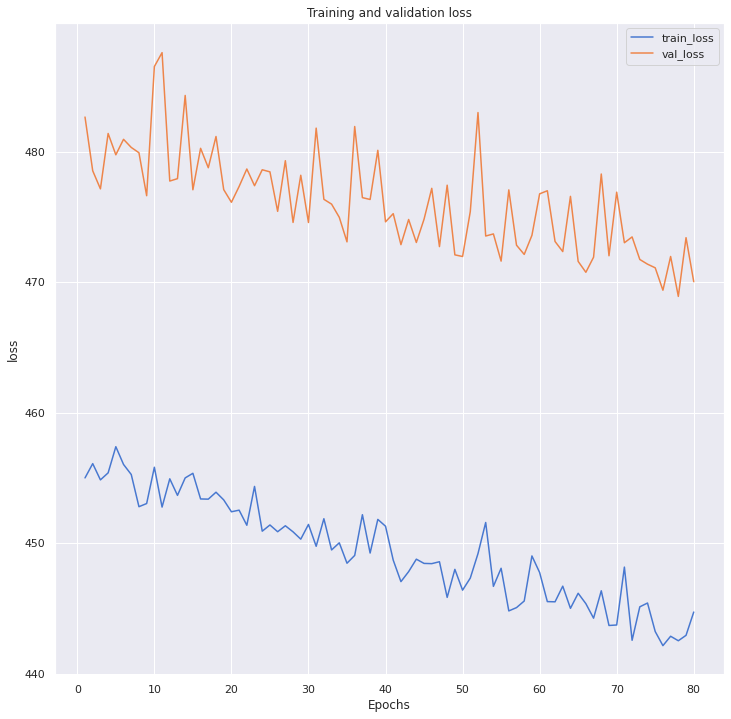

In [49]:
#  loss MAE 可视化
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.figure(figsize = (12,12))
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

    
plot_metric(history, 'loss')

In [50]:
y_pred[y_pred<0] = 11

# 输出结果

In [51]:
true_ID = pd.read_csv('./used_car_sample_submit.csv')
true_ID['SaleID']

sub = pd.DataFrame()
sub['SaleID'] = true_ID['SaleID']
sub['price'] = y_pred
sub.to_csv("ans_nn5.csv",index=False)  

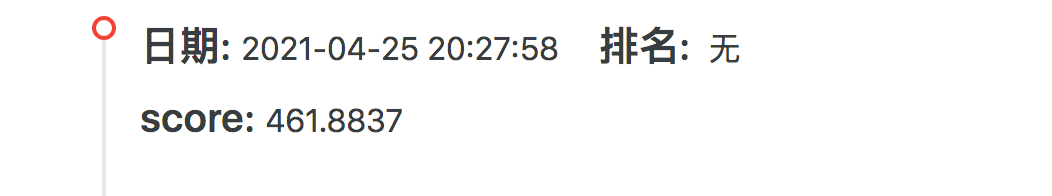